# Capstone Project - The Battle of Neighborhoods

### Introduction

New York City is one of the most ethnically diverse cities in the work, with expats being around 40% of the population in it.
With a huge percentage of expats, there are a lot of restaurants with international cuisines. middle eastern food, Indian food, Chinese food. It is always nice to find your own home country's food in a foreign country to remind you of where you grew up. With that being said, our project will be to help people who want to open their own international restaurant to attract expats or others who like to try new cuisines.

### Problem

You have the money and the means to open your own business, you decide to open a Chinese restaurant in new york city. The question is, if you were to open a Chinese restaurant, where should it be? you probably don't want any competition. Let's find out

### Interest

People who would like to have fewer competitions for their restaurants, so that more customers would come to them (taking into account the food is great of course)

### Data
The Data that we will be using for this project consists of two things:
- New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude. This data set contains the required information. This data set will be used to explore various neighborhoods of new york city. Data source: https://cocl.us/new_york_dataset.
- Chinese restaurants in each neighborhood of new york city. We will get all the Chinese restaurants in the list of neighborhoods of new york city using Foursquare API.

### Methodology 
- GetNew York City data from: https://cocl.us/new_york_dataset
- Find all chinese Resturants in each of the neighbourhoods using FourSquare API 
- Choose the neighbourhoods or Boroughs with the least chinese resturants as potential candidates. 

In [4]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
import geocoder
import os
import folium 
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

We first get the top 50 venues within a 2 kilometers radius using our FourSquare API. Below function will return us the venue id , venue name and category.

In [2]:
def get_venues(lat,lng):
    
    #set variables
    
    lim=100
    radius=2000
    CLIENT_ID = 'VNQLBQOEWWIYFYUDG3SSUO3VV41EPA3GXKAKVEO2OUVZNZBT' # your Foursquare ID
    CLIENT_SECRET = 'GGURMF0DZZLNE3YUZWLP1Z133GHYCQGGBLZPGECLQ4W5IHBL' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            lim)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df
    

Below function will get us venue details

In [3]:
def get_venue_details(venue_id):
    CLIENT_ID = 'VNQLBQOEWWIYFYUDG3SSUO3VV41EPA3GXKAKVEO2OUVZNZBT' # your Foursquare ID
    CLIENT_SECRET = 'GGURMF0DZZLNE3YUZWLP1Z133GHYCQGGBLZPGECLQ4W5IHBL' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        
        venue_details.append([venue_id,venue_name])
    except KeyError:
        pass
        
    column_names=['ID','Name']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


Now we define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [5]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [6]:
# get new york data
new_york_data=get_new_york_data()

In [7]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [8]:
new_york_data.shape

(306, 4)

We check for the number of chinese resturants In each Borough to find the best place to open an chinese resturant, in this case we are looking for neighbourhoods with the lowest number of indian resturants

In [11]:
# prepare neighborhood list that contains chinese resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
chinese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    chinese_resturants=venues[venues['Category']=='Chinese Restaurant']   
    print('(',count,'/',len(new_york_data),')','Chinese Resturants in '+Neighborhood+', '+Borough+':'+str(len(chinese_resturants)))
    for resturant_detail in chinese_resturants.values.tolist():
        id, name , category=resturant_detail
        chinese_rest_ny = chinese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Chinese Resturants in Wakefield, Bronx:1
( 2 / 306 ) Chinese Resturants in Co-op City, Bronx:0
( 3 / 306 ) Chinese Resturants in Eastchester, Bronx:0
( 4 / 306 ) Chinese Resturants in Fieldston, Bronx:0
( 5 / 306 ) Chinese Resturants in Riverdale, Bronx:0
( 6 / 306 ) Chinese Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Chinese Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Chinese Resturants in Woodlawn, Bronx:0
( 9 / 306 ) Chinese Resturants in Norwood, Bronx:1
( 10 / 306 ) Chinese Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Chinese Resturants in Baychester, Bronx:0
( 12 / 306 ) Chinese Resturants in Pelham Parkway, Bronx:3
( 13 / 306 ) Chinese Resturants in City Island, Bronx:1
( 14 / 306 ) Chinese Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Chinese Resturants in University Heights, Bronx:1
( 16 / 306 ) Chinese Resturants in Morris Heights, Bronx:2
( 17 / 306 ) Chinese Resturants in Fordham, Bronx:1
( 18 / 306 ) Chinese Resturants in East Tremont, Bronx:

( 141 / 306 ) Chinese Resturants in Sunnyside, Queens:0
( 142 / 306 ) Chinese Resturants in East Elmhurst, Queens:2
( 143 / 306 ) Chinese Resturants in Maspeth, Queens:0
( 144 / 306 ) Chinese Resturants in Ridgewood, Queens:0
( 145 / 306 ) Chinese Resturants in Glendale, Queens:2
( 146 / 306 ) Chinese Resturants in Rego Park, Queens:2
( 147 / 306 ) Chinese Resturants in Woodhaven, Queens:1
( 148 / 306 ) Chinese Resturants in Ozone Park, Queens:3
( 149 / 306 ) Chinese Resturants in South Ozone Park, Queens:5
( 150 / 306 ) Chinese Resturants in College Point, Queens:3
( 151 / 306 ) Chinese Resturants in Whitestone, Queens:1
( 152 / 306 ) Chinese Resturants in Bayside, Queens:1
( 153 / 306 ) Chinese Resturants in Auburndale, Queens:0
( 154 / 306 ) Chinese Resturants in Little Neck, Queens:5
( 155 / 306 ) Chinese Resturants in Douglaston, Queens:5
( 156 / 306 ) Chinese Resturants in Glen Oaks, Queens:1
( 157 / 306 ) Chinese Resturants in Bellerose, Queens:2
( 158 / 306 ) Chinese Resturants

( 276 / 306 ) Chinese Resturants in Stuyvesant Town, Manhattan:0
( 277 / 306 ) Chinese Resturants in Flatiron, Manhattan:1
( 278 / 306 ) Chinese Resturants in Sunnyside Gardens, Queens:2
( 279 / 306 ) Chinese Resturants in Blissville, Queens:0
( 280 / 306 ) Chinese Resturants in Fulton Ferry, Brooklyn:1
( 281 / 306 ) Chinese Resturants in Vinegar Hill, Brooklyn:2
( 282 / 306 ) Chinese Resturants in Weeksville, Brooklyn:1
( 283 / 306 ) Chinese Resturants in Broadway Junction, Brooklyn:1
( 284 / 306 ) Chinese Resturants in Dumbo, Brooklyn:2
( 285 / 306 ) Chinese Resturants in Manor Heights, Staten Island:2
( 286 / 306 ) Chinese Resturants in Willowbrook, Staten Island:2
( 287 / 306 ) Chinese Resturants in Sandy Ground, Staten Island:0
( 288 / 306 ) Chinese Resturants in Egbertville, Staten Island:0
( 289 / 306 ) Chinese Resturants in Roxbury, Queens:0
( 290 / 306 ) Chinese Resturants in Homecrest, Brooklyn:1
( 291 / 306 ) Chinese Resturants in Middle Village, Queens:1
( 292 / 306 ) Chine

We got the number of resturants in each neighbourhood, we can now group them up to find which boroughs should we aim to open our chinese resturant

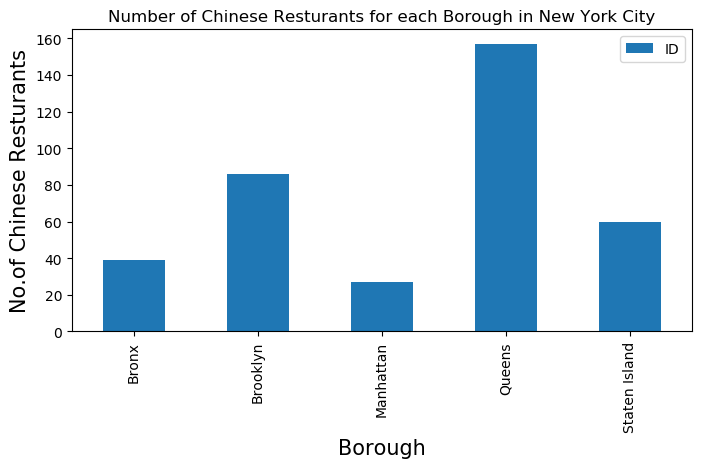

In [13]:
plt.figure(figsize=(8,4), dpi = 100)
plt.title('Number of Chinese Resturants for each Borough in New York City')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Chinese Resturants', fontsize=15)
chinese_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
plt.legend()
plt.show()

In [14]:
chinese_rest_ny.groupby('Borough')['ID'].count()

Borough
Bronx             39
Brooklyn          86
Manhattan         27
Queens           157
Staten Island     60
Name: ID, dtype: int64

As we can see, Manhatten has the least number of chinese resturants (27).

### Conclusion 

If you are trying to open a Chinese restaurant, our advice is to open it in Manhattan, as you will have less competition there.